In [25]:
%matplotlib inline

# On importe les librairies dont on aura besoin pour ce tp
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm as cm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Lieu où se trouve le fichier de base
_DOSSIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\p5\\'

# Fonctions utilisées

In [26]:
def correlation_matrix(data):
    """
        Fonction qui permet de créer une visualisation du lien entre les
        variables 2 à 2
    """

    # Calcule de la matrice
    corr = data.corr()
    cmap = cm.get_cmap('jet', 30)

    # Taille de la figure
    plt.figure(figsize=(15, 15))
    # Création du type d'image
    cax = plt.imshow(data.corr(), interpolation="nearest", cmap=cmap)
    plt.grid(True)

    # Libellés sur les axes
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=10)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    plt.colorbar(cax, ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    plt.tight_layout()
    plt.show()

def dbscan(data_x, nb_samples):
    """
    Test de l'algorithme dbscan
    """

    data_x = StandardScaler().fit_transform(data_x)

    # Compute DBSCAN
    var_db = DBSCAN(eps=0.5, min_samples=nb_samples).fit(data_x)
    core_samples_mask = np.zeros_like(var_db.labels_, dtype=bool)
    core_samples_mask[var_db.core_sample_indices_] = True
    labels = var_db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    mask = (labels == -1)
    reste = -sum(labels[mask])

    print('N =', nb_samples)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Nombre sans clusters : %d' % reste)
    print("Silhouette Coeff : %0.3f" % metrics.silhouette_score(data_x, labels))

    return labels

def affichage_kmeans(datanum, vmin, vmax, step):
    """
    Test de l'algorithme kmeans et affichage de la méthode du coude.
    """

    # Variables
    listing = dict()
    distortions = []

    # Scale des données obligatoire avant la réduction des dimensions
    std_scale = preprocessing.StandardScaler().fit(datanum)
    x_scaled = std_scale.transform(datanum)

    cluster_range = range(vmin, vmax+1, step)

    for i in cluster_range:

        # On fait i clusters avec les données scalées.
        kmeans = KMeans(n_clusters=i,
                        n_init=50,
                        max_iter=500,
                        random_state=10)

        kmeans.fit(x_scaled)
        # Nouvelle colonne avec les conclusions de kmeans
        datanum['labels'] = kmeans.labels_

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        cluster_labels = kmeans.fit_predict(x_scaled)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(x_scaled, cluster_labels)
        distortions.append(kmeans.inertia_)
        listing[i] = silhouette_avg

    # Données du graphique du coude
    clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors": distortions})

    # Graphique du coude
    plt.figure(figsize=(15, 15))
    plt.plot(cluster_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    return listing, clusters_df

def histogramme(data, colon):
    """
    Affichage d'histogrammes
    """

    plt.figure(figsize=(10, 6))
    plt.xlabel('Valeurs')
    plt.ylabel('Décompte')
    titre = 'Histogramme ' + colon
    plt.title(titre)

    # Affichage sans les valeurs NaN
    plt.hist(data[colon][np.isfinite(data[colon])], bins=100)
    plt.show()

def creation_intervalles_days(df_num, nom_colonne, depart_point, frequence, nb_periods):
    """
    Création des intervalles (pour les jours) où vont être mis les variables
    de durée
    """

    # Convertion de la Série d'entrée en DataFrame
    datatemp = pd.DataFrame(df_num[nom_colonne]).astype('datetime64[ns]')

    # Intervalles
    bins_dt = pd.date_range(depart_point,
                            freq=frequence,
                            periods=nb_periods
                           )
    bins_str = bins_dt.astype(str).values

    # Labels des intervalles
    labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]

    # Nom des nouvelles colonnes pour préparer le one-hot encoding
    new_column_name = 'interval_' + nom_colonne

    # df.Date.astype(np.int64)//10**9 - converts datetime values into UNIX epoch
    datatemp[new_column_name] = pd.cut(datatemp[nom_colonne].astype(np.int64)//10**9,
                                       bins=bins_dt.astype(np.int64)//10**9,
                                       labels=labels
                                      )

    # Suppression de la colonne qui existe déjà dans le dataframe final
    del datatemp[nom_colonne]

    # Insertion dans le dataframe qui existait auparavant
    df_num = df_num.join(datatemp, how='right')

    return df_num

def comparaison(datatemp, ligne, colonne):
    """
    Fonction qui déterminer l'intervalle horaire de l'horaire en entrée
    """

    # Cinq comparaisons pour connaitre l'intervalle horaire
    if datatemp.loc[str(ligne), colonne].hour < 8:
        return '[00:00 - 08:00)'
    elif datatemp.loc[str(ligne), colonne].hour < 12:
        return '[08:00 - 12:00)'
    elif datatemp.loc[str(ligne), colonne].hour < 16:
        return '[12:00 - 16:00)'
    elif datatemp.loc[str(ligne), colonne].hour < 20:
        return '[16:00 - 20:00)'
    #Sinon
    return '[20:00 - 00:00)'

def creation_intervalles_heures(df_num, nom_colonne):
    """
    Appel de la fonction pour désigner l'intervalle horaire
    """

    # Convertion de la Série d'entrée en DataFrame
    datatemp = pd.DataFrame(df_num[nom_colonne])

    # Nom des nouvelles colonnes pour préparer le one-hot encoding
    new_column_name = 'interval_' + nom_colonne

    # Pour tous les index, on recherche les données
    for ligne in datatemp.index:
        datatemp.loc[str(ligne), new_column_name] = comparaison(datatemp, ligne, nom_colonne)

    # Suppression de la colonne qui existe déjà dans le dataframe final
    del datatemp[nom_colonne]

    # Insertion dans le dataframe qui existait auparavant
    df_num = df_num.join(datatemp, how='right')

    return df_num

def calcul_sommes(data, df_num):
    """
    Fonction qui va gérer toutes les informations retirées graçe aux dates
    """

    # Colonnes que l'on va créer dans le dataframe vide
    colonnes = ['valeur_facture_1',
                'valeur_facture_2',
                'valeur_last_facture'
               ]

    # Création d'un dataframe vide
    datatemp = pd.DataFrame(columns=colonnes)

    # Création de la liste des valeurs des factures
    aggregations = {'TotalAmount':'sum'}
    liste_amounts = data.groupby('InvoiceNo').agg(aggregations)

    # Pour tous les index, on recherche les données
    for ligne in df_num.index:
        # Récupération de toutes les dates d'achats
        liste_factures = pd.Series(data['InvoiceNo'][data['CustomerID'] == float(ligne)].unique())

        # Récupération de la valeur de la première facture, case 0
        premiere_facture = liste_amounts.loc[liste_factures[0]][0]

        # Et on rajoute ça dans le dataframe créé pour ça
        datatemp.loc[str(ligne), colonnes[0]] = premiere_facture

        # Récupération de la valeur d'autres factures
        if len(liste_factures) > 1:
            # Facture n°2
            deuxieme_facture = liste_amounts.loc[liste_factures[1]][0]

            # Dernière facture
            derniere_facture = liste_amounts.loc[liste_factures[len(liste_factures)-1]][0]

            # Et on rajoute ça dans le dataframe créé pour ça
            datatemp.loc[str(ligne), colonnes[1]] = deuxieme_facture
            datatemp.loc[str(ligne), colonnes[2]] = derniere_facture

    # Insertion dans le dataframe qui existait auparavant
    df_num = df_num.join(datatemp, how='right')

    # Formatage en float
    df_num['valeur_facture_1'] = df_num['valeur_facture_1'].astype(float)
    df_num['valeur_facture_2'] = df_num['valeur_facture_2'].astype(float)
    df_num['valeur_last_facture'] = df_num['valeur_last_facture'].astype(float)

    return df_num

def calcul_dates(data, df_num):
    """
    Fonction qui va gérer toutes les informations retirées graçe aux dates
    """

    # Colonnes que l'on va créer dans le dataframe vide
    colonnes = ['ecart_moy_2_achats',
                'moyenne_horaire',
                'jour_achat_n1',
                'heure_achat_n1',
                'jour_dernier_achat',
                'heure_dernier_achat',
                'ecart_min_2_achats',
                'ecart_max_2_achats',
                'day_of_week'
               ]

    # Création d'un dataframe vide
    datatemp = pd.DataFrame(columns=colonnes)

    # Pour tous les index, on recherche les données
    for ligne in df_num.index:
        # Récupération de toutes les dates d'achats
        dates = pd.Series(data['InvoiceDate'][data['CustomerID'] == float(ligne)].unique())

        # Initialisation des variables au bon type
        somme = datetime.timedelta(0)
        ecart_min = datetime.timedelta(500)
        ecart_max = datetime.timedelta(0)
        res = []

        # Pour toutes les dates, on calcule la différence entre 2 dates
        for i, j in enumerate(dates):
            # Pour calculer l'heure moyenne d'achat
            res.append(dates[i].hour*60 + dates[i].minute)

            # Pour calculer le nombre de jours entre deux achats
            if i != 0:
                somme = somme + (dates[i] - dates[i-1])

                #Comparaison pour les écarts min et max
                if ecart_min > (dates[i] - dates[i-1]):
                    ecart_min = dates[i] - dates[i-1]
                if ecart_max < dates[i] - dates[i-1]:
                    ecart_max = dates[i] - dates[i-1]

        # Vérification qu'il y a eu plus qu'un achat, sinon on enlève la valeur initiale
        if ecart_min == datetime.timedelta(500):
            ecart_min = datetime.timedelta(365)

        if ecart_max == datetime.timedelta(0):
            ecart_max = datetime.timedelta(365)

        # On fait la moyenne à la fin
        if len(dates) > 1:
            moyenne = somme / len(dates)
        else:
            moyenne = datetime.timedelta(365)

        # Formatage des heures et minutes pour l'heure moyenne d'achat
        var_heures = int((sum(res)/len(res))/60)
        var_minutes = int(sum(res)/len(res) - var_heures*60)

        # Et on rajoute ça dans le dataframe créé pour ça
        datatemp.loc[str(ligne), colonnes[0]] = moyenne.days
        datatemp.loc[str(ligne), colonnes[1]] = datetime.time(var_heures,
                                                              var_minutes)
        datatemp.loc[str(ligne), colonnes[2]] = dates[0].date()
        datatemp.loc[str(ligne), colonnes[3]] = datetime.time(dates[0].hour,
                                                              dates[0].minute)
        datatemp.loc[str(ligne), colonnes[4]] = dates[len(dates)-1].date()
        datatemp.loc[str(ligne), colonnes[5]] = datetime.time(dates[len(dates)-1].hour,
                                                              dates[len(dates)-1].minute)
        datatemp.loc[str(ligne), colonnes[6]] = ecart_min.days
        datatemp.loc[str(ligne), colonnes[7]] = ecart_max.days
        datatemp.loc[str(ligne), colonnes[8]] = round(dates.dt.weekday.mean())

    # Insertion dans le dataframe qui existait auparavant
    df_num = df_num.join(datatemp, how='right')

    # Formatage en int
    df_num['ecart_moy_2_achats'] = df_num['ecart_moy_2_achats'].astype(int)
    df_num['ecart_min_2_achats'] = df_num['ecart_min_2_achats'].astype(int)
    df_num['ecart_max_2_achats'] = df_num['ecart_max_2_achats'].astype(int)

    return df_num

def donnees_manquantes(data, nom):
    """
    Données manquantes
    """

    # Données manquantes
    fichier_save = _DOSSIERTRAVAIL + '\\' + nom + '.csv'
    missing_data = data.isnull().sum(axis=0).reset_index()
    missing_data.columns = ['column_name', 'missing_count']
    missing_data['filling_factor'] = (data.shape[0]-missing_data['missing_count'])/data.shape[0]*100
    print(missing_data.sort_values('filling_factor').reset_index(drop=True))

    # Transposition du dataframe de données pour l'analyse univariée
    fichier_save = _DOSSIERTRAVAIL + '\\' + 'transposition.csv'
    data_transpose = data.describe().reset_index().transpose()
    print(data_transpose)

def suppression_labels(df_verif, df_num, nb_cluster):
    """
    # Suppression des petits labels. A améliorer
    """

    # Limite à retravailler
    df_verif = df_verif[df_verif['Count'] > 100]

    # Création de la liste qui va garder les labels à supprimer
    listing = list(range(0, nb_cluster+1))

    for i in df_verif.index:
        listing.remove(i)

    for i in listing:
        df_num = df_num[(df_num['labels'] != i)]

    return df_num


# Nettoyage du dataset

In [27]:
# Récupération du dataset
fichier = 'Online Retail.xlsx'
data = pd.read_excel(_DOSSIER + fichier, error_bad_lines=False)

# Données manquantes
donnees_manquantes(data, "missing_data_1")

   column_name  missing_count  filling_factor
0   CustomerID         135080       75.073306
1  Description           1454       99.731689
2    InvoiceNo              0      100.000000
3    StockCode              0      100.000000
4     Quantity              0      100.000000
5  InvoiceDate              0      100.000000
6    UnitPrice              0      100.000000
7      Country              0      100.000000
                 0        1        2        3      4      5      6      7
index        count     mean      std      min    25%    50%    75%    max
Quantity    541909  9.55225  218.081   -80995      1      3     10  80995
UnitPrice   541909  4.61111  96.7599 -11062.1   1.25   2.08   4.13  38970
CustomerID  406829  15287.7   1713.6    12346  13953  15152  16791  18287


Suppression de données qui ne nous servent pas :
* Frais d'Amazon
* Factures de remboursement
* Factures anonymes

In [28]:
data = data[data['StockCode'] != "AMAZONFEE"]
data = data[data['Quantity'] > 0]
data = data[pd.notnull(data['CustomerID'])]

Rajout de la somme finale pour les factures

In [29]:
# Calcul de la somme par article des factures
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

Extration de données du dataset initial qui sont "cachées" :
* Somme totale par facture
* Nombre d'articles par facture
* Nombre d'articles différents par facture
* Nombre de factures par client

In [30]:
# Premiers calculs qui sont fait via l'appel d'un dictionnaire
aggregations = {'TotalAmount':'sum',
                'Quantity':'sum',
                'InvoiceNo': ['count', pd.Series.nunique]
               }

df_num = data.groupby('CustomerID').agg(aggregations)

# Renommage des colonnes du résultat de l'aggrégation
df_num.columns = ['1', '2', '3', '4']
df_num = df_num.rename(index=str, columns={"1": "somme_total",
                                           "2": "nb_article_total",
                                           "3": "nb_categorie_total",
                                           "4": "nb_factures"})

Calculs de moyennes :
* Moyenne d'articles par facture
* Moyenne de la somme par facture
* Moyenne d'articles différents (catégorie) par facture
* Moyenne de la somme par catégorie

In [31]:
# Calculs de moyennes
df_num['mean_nb_article_facture'] = df_num['nb_article_total']/df_num['nb_factures']
df_num['mean_somme_par_facture'] = df_num['somme_total']/df_num['nb_factures']
df_num['mean_nb_categorie_facture'] = df_num['nb_categorie_total']/df_num['nb_factures']
df_num['mean_somme_par_article'] = df_num['somme_total']/df_num['nb_article_total']

Toujours dans l'idée d'extraire des donneés "cachées", les deux fonctions calcul_dates et calcul_sommes vont traiter des informations temporelles et des valeurs pour différentes factures choisies (la première, la seconde et la dernière)

In [32]:
# Appel de la fonction qui va gérer tout à partir des dates
df_num = calcul_dates(data, df_num)

# Appel de la fonction qui gérer les différentes factures
df_num = calcul_sommes(data, df_num)

Afin de pouvoir exploiter les données issues de la fonction calcul_dates, on les transforme en intervalles de jours (pour la première fonction) ou horaires (pour la deuxième fonction) à la manière d'un one-hot encoding

In [33]:
# Formatage en intervalle des dates
nom_colonne = ['jour_achat_n1', 'jour_dernier_achat']

# Création des intervalles journaliers pour les nom_colonne ci-dessus
for i in range(0, len(nom_colonne)):
    df_num = creation_intervalles_days(df_num,
                                       nom_colonne[i],
                                       '2010-11-01',    # date de départ de l'intervalle
                                       '1M',            # intervalle d'un mois
                                       14               # nombre d'intervalles
                                      )
    del df_num[nom_colonne[i]]

In [34]:
# Formatage en intervalle des heures
nom_colonne = ['moyenne_horaire', 'heure_achat_n1', 'heure_dernier_achat']

# Création des intervalles horaires pour les nom_colonne ci-dessus
for i in range(0, len(nom_colonne)):
    df_num = creation_intervalles_heures(df_num, nom_colonne[i])

    # Suppresion de la colonne d'origine
    del df_num[nom_colonne[i]]

Pour pouvoir utiliser ces données avec des algorithmes de clustering non supervisés, on les encode avec un label encoding

In [35]:
# Label encoding
liste_criteres = ['interval_moyenne_horaire',
                  'interval_jour_achat_n1',
                  'interval_heure_achat_n1',
                  'interval_jour_dernier_achat',
                  'interval_heure_dernier_achat'
                 ]

labelencode = preprocessing.LabelEncoder()

for critere in liste_criteres:
    labelencode.fit(df_num[critere])
    df_num[critere] = labelencode.transform(df_num[critere])

Affichage de la matrice de corrélation

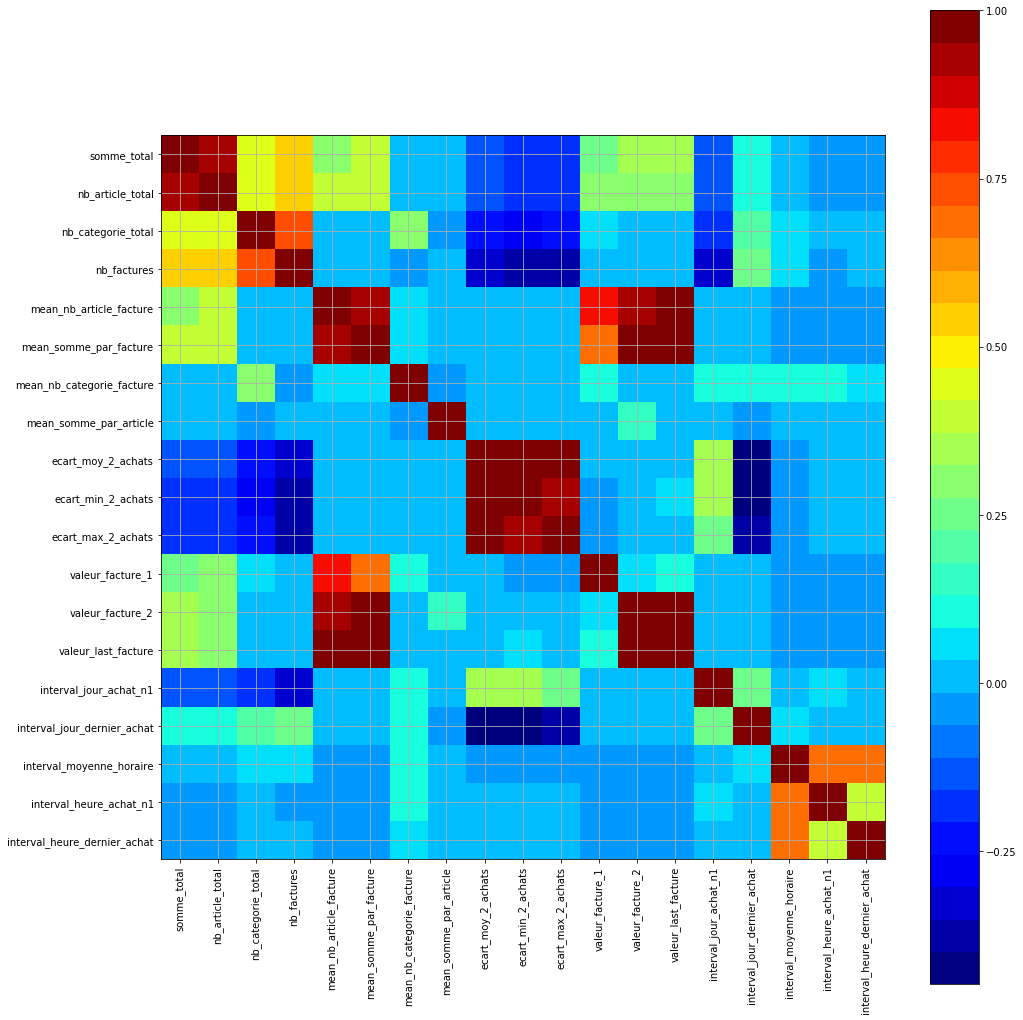

In [36]:
correlation_matrix(df_num)

Certaines données ne sont finalement pas inutiles, elles sont supprimées

In [37]:
del df_num['interval_heure_dernier_achat']
del df_num['interval_jour_dernier_achat']
del df_num['valeur_facture_2']
del df_num['valeur_last_facture']

# Exploration

Deux méthodes de clustering non supervisées sont testées :
* Kmeans
* DBSCan

Pour le Kmeans, la méthode du coude va nous permettre d'obtenir un nombre de clusters optimal, ou du moins une approximation de ce nombre.

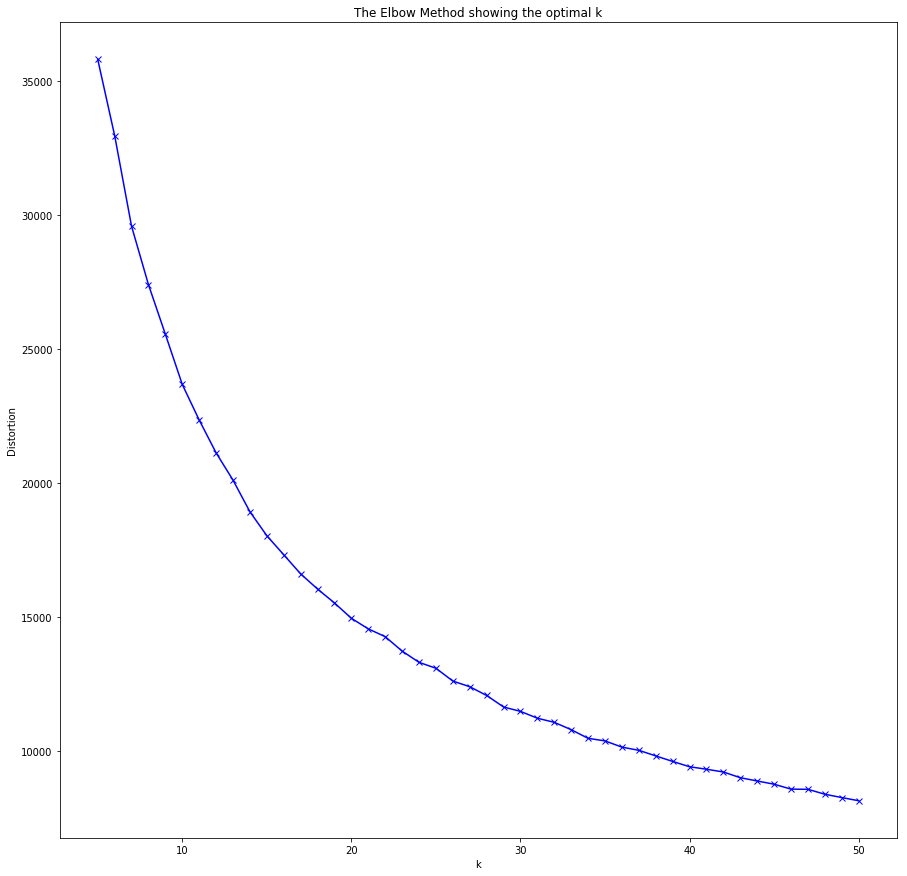

In [38]:
# Méthode du KMeans (coude)
df_num.fillna(0, inplace=True)
res, dico = affichage_kmeans(df_num, 5, 50, 1)

Le nombre choisi de cluster est de 20

In [39]:
nb_cluster = 20

# Scale des données obligatoire pour le Kmeans
std_scale = preprocessing.StandardScaler().fit(df_num)
x_scaled = std_scale.transform(df_num)

kmeans = KMeans(n_clusters=nb_cluster, n_init=50, max_iter=500, random_state=10)

kmeans.fit(x_scaled)

# Nouvelle colonne avec les conclusions de kmeans
df_num['labels'] = kmeans.labels_

Petite vérification grace à un histogramme

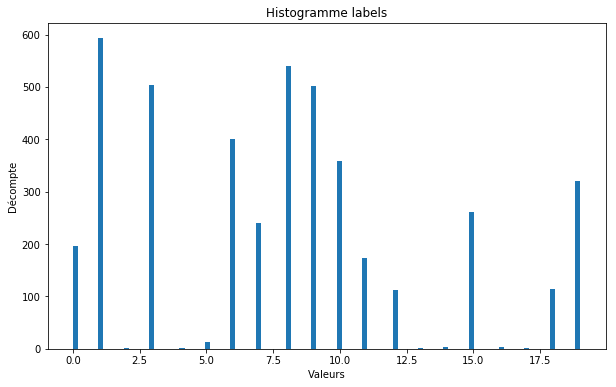

In [40]:
# Partie de verification pour voir les labels qui ont étés créés
df_verif = df_num.groupby('labels').mean()
df_verif['Count'] = df_num.groupby('labels').somme_total.count()

# Répartition des labels
histogramme(df_num, 'labels')

La seconde méthode testée : DBScan

In [41]:
# Tester dbscan
for i in range(1, 5):
    liste = dbscan(df_num, i)

N = 1
Estimated number of clusters: 1859
Nombre sans clusters : 0
Silhouette Coeff : -0.016
N = 2
Estimated number of clusters: 303
Nombre sans clusters : 1556
Silhouette Coeff : -0.163
N = 3
Estimated number of clusters: 146
Nombre sans clusters : 1870
Silhouette Coeff : -0.201
N = 4
Estimated number of clusters: 100
Nombre sans clusters : 2111
Silhouette Coeff : -0.219


Certains utilisateurs sont uniques, ou presque. Ils ne sont pas gardés pour notre étude finale

In [42]:
# Suppresion des labels de bruit
dumb = suppression_labels(df_verif, df_num, nb_cluster)

Analyses univarivée et bivariée du nouveau dataset

In [43]:
donnees_manquantes(df_num, "missing_data_2")

                  column_name  missing_count  filling_factor
0                 somme_total              0           100.0
1    interval_moyenne_horaire              0           100.0
2      interval_jour_achat_n1              0           100.0
3            valeur_facture_1              0           100.0
4                 day_of_week              0           100.0
5          ecart_max_2_achats              0           100.0
6          ecart_min_2_achats              0           100.0
7     interval_heure_achat_n1              0           100.0
8          ecart_moy_2_achats              0           100.0
9   mean_nb_categorie_facture              0           100.0
10     mean_somme_par_facture              0           100.0
11    mean_nb_article_facture              0           100.0
12                nb_factures              0           100.0
13         nb_categorie_total              0           100.0
14           nb_article_total              0           100.0
15     mean_somme_par_ar

Exportation du dataset créé

In [44]:
# Export
df_num.to_csv('C:\\Users\\Toni\\Desktop\\dataset_p5.csv')